In [1]:
import geopandas as gpd
import yaml

# Gasoductos

In [2]:
shapefile = "/home/aninotna/magister/tesis/justh2_pipeline/data/generadoras/Gasoducto.shp"   # Ruta a tu archivo .shp
gdf = gpd.read_file(shapefile)
print("📌 Columnas disponibles en el SHP:")
print(gdf.columns.tolist())
print("\n📌 Primeras filas para ver los datos:")
print(gdf.head())

📌 Columnas disponibles en el SHP:
['ID_GASODUC', 'NOMBRE', 'COMBUSTIBL', 'LONG_KM', 'DIAMETR_MM', 'CAPAC_M3_H', 'DISENO_MPA', 'OPERACI_MP', 'V_GAS', 'PROPIEDAD', 'F_OPERACIO', 'COORD_ESTE', 'COOR_NORTE', 'HUSO', 'DATUM', 'REGION', 'PROVINCIA', 'COMUNA', 'FUENTE_BAS', 'FECH_CREA', 'FECH_ACT', 'SHAPE_STLe', 'geometry']

📌 Primeras filas para ver los datos:
   ID_GASODUC                                             NOMBRE   COMBUSTIBL  \
0         113  GASODUCTO SAN BERNARDO QUILLOTA 16 PULG. ( LAT...  GAS NATURAL   
1         133            GASODUCTO QUINTERO-QUILLOTA 24 PULGADAS  GAS NATURAL   
2         134  GASODUCTO SAN BERNARDO QUILLOTA 24 PULG. (RATO...  GAS NATURAL   
3           0                             GASODUCTO CONCON-LOVEN  GAS NATURAL   
4           0                                  GASODUCTO TPI-CTQ  GAS NATURAL   

   LONG_KM  DIAMETR_MM  CAPAC_M3_H  DISENO_MPA  OPERACI_MP    V_GAS  \
0    14.61       406.4     50000.0         8.0         4.8    95000   
1    28.10    

In [7]:
from shapely.geometry import Point
from shapely.ops import unary_union
import pandas as pd

In [16]:
# 2) Extremos (terminales potenciales)
def endpoints(geom):
    if geom.geom_type == "LineString":
        xs, ys = geom.coords[0], geom.coords[-1]
        return [Point(xs), Point(ys)]
    return []

ends = []
for idx, row in gdf.iterrows():
    for p in endpoints(row.geometry):
        ends.append({"edge_id": idx, "geometry": p})
ends_gdf = gpd.GeoDataFrame(ends, geometry="geometry", crs=gdf.crs)

# 3) Intersecciones entre líneas (rápido y sin O(n^2) total)
# Usamos el sindex para evitar probar todas con todas
ints = []
sindex = gdf.sindex
for i, geom in gdf.geometry.items():
    candidates = list(sindex.intersection(geom.bounds))
    candidates = [j for j in candidates if j > i]  # evitar duplicados y self
    for j in candidates:
        inter = geom.intersection(gdf.geometry[j])
        if inter.is_empty:
            continue
        if inter.geom_type == "Point":
            ints.append({"edge_a": i, "edge_b": j, "geometry": inter})
        elif inter.geom_type == "MultiPoint":
            for pt in inter.geoms:
                ints.append({"edge_a": i, "edge_b": j, "geometry": pt})

ints_gdf = gpd.GeoDataFrame(ints, geometry="geometry", crs=gdf.crs)

# 4) Unificar y deduplicar nodos con tolerancia
nodes_raw = gpd.GeoDataFrame(
    pd.concat([ends_gdf[["geometry"]], ints_gdf[["geometry"]]], ignore_index=True),
    geometry="geometry", crs=gdf.crs
)

# Snap/Dedup (discretización por grilla para agrupar cercanos)
tol = 100.0  # metros (ajusta)
snapx = (nodes_raw.geometry.x // tol) * tol
snapy = (nodes_raw.geometry.y // tol) * tol
nodes_raw["bucket"] = list(zip(snapx, snapy))

# Tomar el punto representativo por bucket
nodes = nodes_raw.groupby("bucket", as_index=False).first()[["bucket", "geometry"]]  # => conservar 'bucket' para el join/merge
nodes = gpd.GeoDataFrame(nodes, geometry="geometry", crs=gdf.crs)

# 5) Calcular grado (cuántas líneas tocan cada nodo)
# Contamos cuántos extremos/intersecciones caen en cada bucket
deg = nodes_raw.groupby("bucket").size().reset_index(name="degree")  # (igual)

nodes = nodes.merge(deg, on="bucket", how="left")  # => usar merge explícito evita KeyError por índice


# Clasificación simple
def classify(d):
    if d >= 3: return "junction"
    if d == 1: return "terminal"
    return "pass_through"

nodes["kind"] = nodes["degree"].apply(classify)

# Volver a WGS84 para Calliope
nodes_wgs84 = nodes.to_crs(4326)
gdf_wgs84 = gdf.to_crs(4326)

# IDs legibles
nodes_wgs84["node_id"] = [
    f"N{i:04d}" for i in range(len(nodes_wgs84))
]

# Exporta para revisar / unir en Calliope
nodes_wgs84[["node_id","kind","degree","geometry"]].to_file("gas_nodes.geojson", driver="GeoJSON")
gdf_wgs84.to_file("gas_edges.geojson", driver="GeoJSON")

In [25]:
# === Cargar nodos y edges y llevar a CRS métrico (UTM 19S) ===
nodes = gpd.read_file("gas_nodes.geojson").to_crs(32719)
edges = gpd.read_file("gas_edges.geojson").to_crs(32719)

# Asegurar que existe 'node_id'
assert "node_id" in nodes.columns, "gas_nodes.geojson debe tener 'node_id'."

# Función: extremos de una geometría de tramo
def line_endpoints(geom):
    if geom.geom_type == "LineString":
        return Point(geom.coords[0]), Point(geom.coords[-1])
    elif geom.geom_type == "MultiLineString":
        ls = max(list(geom.geoms), key=lambda g: g.length)
        return Point(ls.coords[0]), Point(ls.coords[-1])
    return None, None

def nearest_two_ids(pt, nodes_gdf):
    # ventana rápida con sindex (opcional)
    cand = nodes_gdf
    if nodes_gdf.sindex:
        idx = list(nodes_gdf.sindex.intersection(pt.buffer(1500).bounds))
        cand = nodes_gdf.iloc[idx] if idx else nodes_gdf
    d = cand.geometry.distance(pt)
    top2 = d.nsmallest(2)
    ids = list(cand.loc[top2.index, "node_id"])
    return ids, list(top2.values)

from_nodes, to_nodes = [], []
warn_same = 0
tol_m = 200  # tolerancia en metros para revisar emparejamientos raros
for _, r in edges.iterrows():
    p0, p1 = line_endpoints(r.geometry)
    if p0 is None: from_nodes.append(None); to_nodes.append(None); continue
    ids0, _ = nearest_two_ids(p0, nodes)
    ids1, _ = nearest_two_ids(p1, nodes)
    n0 = ids0[0]
    n1 = ids1[0] if ids1[0] != n0 else (ids1[1] if len(ids1) > 1 else ids1[0])  # => usar 2º si coincide
    from_nodes.append(n0)
    to_nodes.append(n1)
edges["from_node"] = from_nodes
edges["to_node"] = to_nodes
edges.to_crs(4326).to_file("gas_edges.geojson", driver="GeoJSON")
print("✅ gas_edges.geojson actualizado con from/to distintos cuando es posible.")

# Opcional: alerta si algún match quedó lejos
far = ((edges["from_node"].isna()) | (edges["to_node"].isna()))
if far.any():
    print("⚠ Hay tramos sin mapeo de nodos. Revisa geometrías inválidas o CRS.")

# Guardar actualizado en WGS84
edges.to_crs(4326).to_file("gas_edges.geojson", driver="GeoJSON")
print("✅ gas_edges.geojson actualizado con from_node y to_node.")
if warn_same:
    print(f"ℹ Aviso: {warn_same} tramos mapeados con el mismo nodo en ambos extremos (revisa tol/distancias).")


✅ gas_edges.geojson actualizado con from/to distintos cuando es posible.
✅ gas_edges.geojson actualizado con from_node y to_node.


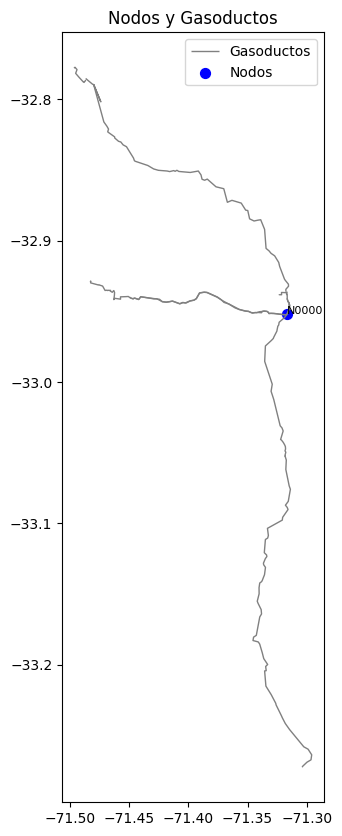

In [26]:
import matplotlib.pyplot as plt

# Leer los archivos .geojson
nodes_gdf = gpd.read_file("gas_nodes.geojson")
edges_gdf = gpd.read_file("gas_edges.geojson")

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar edges (líneas)
edges_gdf.plot(ax=ax, color="gray", linewidth=1, label="Gasoductos")

# Dibujar nodos
nodes_gdf.plot(
    ax=ax, 
    color=nodes_gdf["kind"].map({"terminal": "red", "junction": "blue", "pass_through": "green"}), 
    markersize=50,
    label="Nodos"
)

# Añadir etiquetas con el node_id
for x, y, label in zip(nodes_gdf.geometry.x, nodes_gdf.geometry.y, nodes_gdf["node_id"]):
    ax.text(x, y, label, fontsize=8)

plt.legend()
plt.title("Nodos y Gasoductos")
plt.show()

In [20]:
LHV_KWH_M3 = 10  # poder calorífico inferior del gas natural
config_path = "model_config"


In [21]:
import os
def load_yaml_if_exists(path):
    if os.path.exists(path):
        with open(path, "r") as f:
            return yaml.safe_load(f) or {}
    return {}

In [27]:
if "node_id" not in nodes_gdf.columns or "kind" not in nodes_gdf.columns:
    raise ValueError("gas_nodes.geojson debe tener columnas 'node_id' y 'kind'.")
if not all(col in edges_gdf.columns for col in ["from_node", "to_node"]):
    raise ValueError("gas_edges.geojson debe tener columnas 'from_node' y 'to_node'.")


In [28]:
node_types = {}
for _, row in nodes_gdf.iterrows():
    if row["kind"] == "terminal":
        while True:
            choice = input(
                f"¿Nodo {row['node_id']} ({row.geometry.y:.4f}, {row.geometry.x:.4f}) es "
                "[E]ntrada gas_supply o [S]alida gas_demand? "
            ).strip().lower()
            if choice in ["e", "s"]:
                node_types[row["node_id"]] = "gas_supply" if choice == "e" else "gas_demand"
                break
    else:
        node_types[row["node_id"]] = "gas_node"


# === 1. Generar locations.yaml ===
locations_yaml = {}
for _, row in nodes_gdf.iterrows():
    tech_name = node_types[row["node_id"]]
    locations_yaml[row["node_id"]] = {
        "coordinates": {
            "lat": float(row.geometry.y),
            "lon": float(row.geometry.x)
        },
        "techs": {tech_name: {}}
    }

# === 2. Generar links_transmision.yml ===
links_yaml = {}
for _, row in edges_gdf.iterrows():
    cap_m3h = row.get("CAPAC_M3_H", None)
    cap_mw = None
    if cap_m3h and cap_m3h > 0:
        cap_mw = round((cap_m3h * LHV_KWH_M3) / 1000, 2)

    link_id = f"{row['from_node']},{row['to_node']}"
    links_yaml[link_id] = {
        "techs": {
            "pipeline_gas": {
                "constraints": {
                    "energy_eff": 0.99
                }
            }
        }
    }
    if cap_mw:
        links_yaml[link_id]["techs"]["pipeline_gas"]["constraints"]["energy_cap"] = cap_mw

# === 3. Generar techs.yaml ===
techs_yaml = {
    "gas_supply": {
        "base_tech": "supply_plus",
        "carrier_out": "gas"
    },
    "gas_demand": {
        "base_tech": "demand",
        "carrier": "gas"
    },
    "gas_node": {
        "base_tech": "transmission",
        "carrier": "gas",
        "constraints": {"energy_eff": 1.0}
    },
    "pipeline_gas": {
        "base_tech": "transmission",
        "carrier": "gas"
    }
}

# === Guardar en model_config/ ===
os.makedirs("model_config", exist_ok=True)

with open("model_config/locations.yaml", "w") as f:
    yaml.dump(locations_yaml, f, sort_keys=False)

with open("model_config/links_transmision.yml", "w") as f:
    yaml.dump(links_yaml, f, sort_keys=False)

with open("model_config/techs.yaml", "w") as f:
    yaml.dump(techs_yaml, f, sort_keys=False)

print("✅ Archivos generados en model_config/: locations.yaml, links_transmision.yml, techs.yaml")

✅ Archivos generados en model_config/: locations.yaml, links_transmision.yml, techs.yaml


# Hidroelectricas

In [5]:
shapefile = "/home/aninotna/magister/tesis/justh2_pipeline/data/generadoras/Hidroeléctricas.shp"   # Ruta a tu archivo .shp
gdf = gpd.read_file(shapefile)
print("📌 Columnas disponibles en el SHP:")
print(gdf.columns.tolist())
print("\n📌 Primeras filas para ver los datos:")
print(gdf.head())

📌 Columnas disponibles en el SHP:
['ID_GE_HIDR', 'NOMBRE', 'PROPIEDAD', 'TIPO', 'MEDIO_GENE', 'COMBUSTIBL', 'POTENCIAMW', 'UNIDADES', 'RCA', 'SIST_ELECT', 'ESTADO', 'F_OPERACIO', 'COORD_ESTE', 'COORD_NORT', 'HUSO', 'DATUM', 'REGION', 'PROVINCIA', 'COMUNA', 'FUENTE_BAS', 'FECH_CREA', 'FECH_ACT', 'geometry']

📌 Primeras filas para ver los datos:
   ID_GE_HIDR        NOMBRE           PROPIEDAD               TIPO MEDIO_GENE  \
0          26        BLANCO         COLBUN S.A.  HIDRAULICA PASADA       None   
1          44  CHACABUQUITO         COLBUN S.A.  HIDRAULICA PASADA       None   
2         100    EL TARTARO  WENKE Y CIA. LTDA.  HIDRAULICA PASADA       PMGD   
3         123      HORNITOS  RIO TRANQUILO S.A.  HIDRAULICA PASADA       None   
4         129        JUNCAL         COLBUN S.A.  HIDRAULICA PASADA       None   

  COMBUSTIBL  POTENCIAMW  UNIDADES       RCA SIST_ELECT  ... COORD_NORT  \
0  NO APLICA    52.86750         1      None        SEN  ...  6357124.0   
1  NO APLICA    2

In [11]:
print("\n📌 Tipo de geometría:")
print(gdf.geom_type.unique())


📌 Tipo de geometría:
[]


In [7]:
nombre_campo = "NOMBRE"             # campo nombre en el SHP
campo_capacidad = "POTENCIAMW"      # campo de capacidad instalada (MW)

In [12]:
locations = {}
for idx, row in gdf.iterrows():
    nombre = str(row[nombre_campo]).strip().replace(" ", "_")
    cap = float(row[campo_capacidad]) if campo_capacidad in gdf.columns else 0.0

    if row.geometry.geom_type == "Point":
        lon, lat = row.geometry.x, row.geometry.y
    else:
        lon, lat = row.geometry.centroid.x, row.geometry.centroid.y
    
    techs_block = {
        "hydro_run_of_river": {
            "constraints": {
                "energy_cap": cap
            }
        }
    }

    locations[nombre] = {
        "coordinates": [float(lon), float(lat)],
        "techs": techs_block
    }

yaml_data = { "locations": locations }

with open("locations_hidro.yml", "w", encoding="utf-8") as f:
    yaml.dump(yaml_data, f, sort_keys=False, allow_unicode=True)

print("✅ Archivo YAML generado: locations_hidro.yml")


✅ Archivo YAML generado: locations_hidro.yml


# Eolicas

In [13]:
shapefile = "/home/aninotna/magister/tesis/justh2_pipeline/data/generadoras/Eólicas.shp"   # Ruta a tu archivo .shp
gdf = gpd.read_file(shapefile)
print("📌 Columnas disponibles en el SHP:")
print(gdf.columns.tolist())
print("\n📌 Primeras filas para ver los datos:")
print(gdf.head())

📌 Columnas disponibles en el SHP:
['ID_GE_EOLI', 'NOMBRE', 'PROPIEDAD', 'TIPO', 'MEDIO_GENE', 'COMBUSTIBL', 'POTENCIAMW', 'UNIDADES', 'RCA', 'SIST_ELECT', 'ESTADO', 'F_OPERACIO', 'COORD_ESTE', 'COORD_NORT', 'HUSO', 'DATUM', 'REGION', 'PROVINCIA', 'COMUNA', 'FUENTE_BAS', 'FECH_CREA', 'FECH_ACT', 'geometry']

📌 Primeras filas para ver los datos:
Empty GeoDataFrame
Columns: [ID_GE_EOLI, NOMBRE, PROPIEDAD, TIPO, MEDIO_GENE, COMBUSTIBL, POTENCIAMW, UNIDADES, RCA, SIST_ELECT, ESTADO, F_OPERACIO, COORD_ESTE, COORD_NORT, HUSO, DATUM, REGION, PROVINCIA, COMUNA, FUENTE_BAS, FECH_CREA, FECH_ACT, geometry]
Index: []

[0 rows x 23 columns]


In [14]:
locations = {}
for idx, row in gdf.iterrows():
    nombre = str(row[nombre_campo]).strip().replace(" ", "_")  # reemplazar espacios por _
    cap = float(row[campo_capacidad]) if campo_capacidad in gdf.columns else 0.0

    # Coordenadas
    if row.geometry.geom_type == "Point":
        lon, lat = row.geometry.x, row.geometry.y
    else:
        lon, lat = row.geometry.centroid.x, row.geometry.centroid.y

    # Bloque de tecnologías
    techs_block = {
        "wind_onshore": {
            "constraints": {
                "energy_cap": cap
            }
        }
    }

    # Agregar al diccionario de locations
    locations[nombre] = {
        "coordinates": [float(lon), float(lat)],
        "techs": techs_block
    }

# === YAML final ===
yaml_data = {"locations": locations}

# Guardar archivo YAML
with open("locations_eolicas.yml", "w", encoding="utf-8") as f:
    yaml.dump(yaml_data, f, sort_keys=False, allow_unicode=True)

print("✅ Archivo YAML generado: locations_eolicas.yml")

✅ Archivo YAML generado: locations_eolicas.yml


# Bioenergia

In [15]:
shapefile = "/home/aninotna/magister/tesis/justh2_pipeline/data/generadoras/Bioenergía.shp"   # Ruta a tu archivo .shp
gdf = gpd.read_file(shapefile)
print("📌 Columnas disponibles en el SHP:")
print(gdf.columns.tolist())
print("\n📌 Primeras filas para ver los datos:")
print(gdf.head())

📌 Columnas disponibles en el SHP:
['ID_GE_BIO', 'NOMBRE', 'PROPIEDAD', 'TIPO', 'MEDIO_GENE', 'COMBUSTIBL', 'POTENCIAMW', 'UNIDADES', 'RCA', 'SIST_ELECT', 'ESTADO', 'F_OPERACIO', 'COORD_ESTE', 'COORD_NORT', 'HUSO', 'DATUM', 'REGION', 'PROVINCIA', 'COMUNA', 'FUENTE_BAS', 'FECH_CREA', 'FECH_ACT', 'geometry']

📌 Primeras filas para ver los datos:
   ID_GE_BIO                 NOMBRE                  PROPIEDAD        TIPO  \
0         24               EL MOLLE      STERICYCLE URBANO SPA  BIOENERGIA   
1         37  LOMA LOS COLORADOS II           KDM ENERGIA S.A.  BIOENERGIA   
2         58           DONA JAVIERA  DONA JAVIERA VALLEDOR SPA  BIOENERGIA   

  MEDIO_GENE COMBUSTIBL  POTENCIAMW  UNIDADES        RCA SIST_ELECT  ...  \
0       PMGD     BIOGAS      4.1456         6   126/2015        SEN  ...   
1       None     BIOGAS     19.8400        14   344/2010        SEN  ...   
2       PMGD     BIOGAS      1.9000         3  NO APLICA        SEN  ...   

  COORD_NORT    HUSO     DATUM  REGIO

In [16]:
locations = {}
for idx, row in gdf.iterrows():
    nombre = str(row[nombre_campo]).strip().replace(" ", "_")  # sin espacios
    cap = float(row[campo_capacidad]) if campo_capacidad in gdf.columns else 0.0

    # Coordenadas
    if row.geometry.geom_type == "Point":
        lon, lat = row.geometry.x, row.geometry.y
    else:
        lon, lat = row.geometry.centroid.x, row.geometry.centroid.y

    techs_block = {
        "bioenergy": {
            "constraints": {
                "energy_cap": cap
            }
        }
    }

    locations[nombre] = {
        "coordinates": [float(lon), float(lat)],
        "techs": techs_block
    }

yaml_data = {"locations": locations}

# === GUARDAR YAML ===
with open("locations_bioenergia.yml", "w", encoding="utf-8") as f:
    yaml.dump(yaml_data, f, sort_keys=False, allow_unicode=True)

print("✅ Archivo YAML generado: locations_bioenergia.yml")


✅ Archivo YAML generado: locations_bioenergia.yml


# Lineas de transmisión

In [17]:
shapefile = "/home/aninotna/magister/tesis/justh2_pipeline/data/generadoras/Línea_de_Transmisión.shp"   # Ruta a tu archivo .shp
gdf = gpd.read_file(shapefile)
print("📌 Columnas disponibles en el SHP:")
print(gdf.columns.tolist())
print("\n📌 Primeras filas para ver los datos:")
print(gdf.head())

📌 Columnas disponibles en el SHP:
['ID_LIN_TRA', 'SUBTIPO', 'NOMBRE', 'CIRCUITO', 'TIPO', 'F_OPERACIO', 'LONG_KM', 'TRAMO', 'PROPIEDAD', 'TENSION_KV', 'RCA', 'SIST_ELECT', 'ESTADO', 'REGION', 'PROVINCIA', 'COMUNA', 'FUENTE_BAS', 'FECH_CREA', 'FECH_ACT', 'SHAPE_STLe', 'geometry']

📌 Primeras filas para ver los datos:
   ID_LIN_TRA  SUBTIPO                                             NOMBRE  \
0          45      103                        SAN PEDRO - LAS VEGAS 110KV   
1         928      100  POLPAICO (TRANSELEC) - SECCIONADORA LO AGUIRRE...   
2          22      101              CENTRAL NEHUENCO III - SAN LUIS 220KV   
3         942      103                      TOTORALILLO - ACONCAGUA 110KV   
4         354      103                  MIRAFLORES - MARGA MARGA 110KV L1   

  CIRCUITO      TIPO  F_OPERACIO    LONG_KM  \
0       C1     ZONAL  2015/01/01  29.413816   
1       C1  NACIONAL  2005/05/07  29.363015   
2       C1  DEDICADO  2002/01/01   1.080923   
3  C1 - C2     ZONAL  0000/00/0

In [2]:
from shapely.geometry import LineString
from shapely.ops import nearest_points
from math import radians, cos, sin, asin, sqrt


In [3]:
def haversine(lon1, lat1, lon2, lat2):
    # Radio de la Tierra en km
    R = 6371.0
    dlon = radians(lon2 - lon1)
    dlat = radians(lat2 - lat1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    return R * c

In [4]:
def find_closest_node(coord, nodes, max_distance_km=10):
    closest = None
    min_dist = float('inf')
    for name, coords in nodes.items():
        dist = haversine(coord[0], coord[1], coords[0], coords[1])
        if dist < min_dist and dist <= max_distance_km:
            min_dist = dist
            closest = name
    return closest

In [5]:
shapefile = "/home/aninotna/magister/tesis/justh2_pipeline/data/generadoras/Línea_de_Transmisión.shp"
locations_yaml = "/home/aninotna/magister/tesis/justh2_pipeline/scripts/calliope/model_config/locations.yaml"


In [6]:
gdf = gpd.read_file(shapefile)


In [7]:
# === CARGA LOCATIONS ===
with open(locations_yaml, 'r', encoding='utf-8') as f:
    locs_data = yaml.safe_load(f)

nodes_coords = {name: data["coordinates"] for name, data in locs_data["locations"].items()}


In [8]:
# === GENERAR LINKS ===
links = {}
for _, row in gdf.iterrows():
    nombre = str(row['NOMBRE']).strip().replace(" ", "_").replace("-", "_")
    geometry = row.geometry
    if geometry is None or not isinstance(geometry, LineString):
        continue

    coords = list(geometry.coords)
    if len(coords) < 2:
        continue

    start_coord = coords[0]
    end_coord = coords[-1]

    from_node = find_closest_node(start_coord, nodes_coords)
    to_node = find_closest_node(end_coord, nodes_coords)

    if not from_node or not to_node:
        print(f"⚠️ No se encontraron nodos cercanos para {nombre}")
        continue

    key_name = f"{from_node},{to_node}"
    tension = float(row['TENSION_KV']) if 'TENSION_KV' in row and row['TENSION_KV'] else 0
    longitud = float(row['LONG_KM']) if 'LONG_KM' in row and row['LONG_KM'] else 0

    links[key_name] = {
        "techs": {
            "transmission": {
                "constraints": {
                    "energy_cap": tension,
                    "distance": longitud
                }
            }
        }
    }

# === GUARDAR YAML ===
yaml_data = {"links": links}
with open("links_transmision.yml", "w", encoding="utf-8") as f:
    yaml.dump(yaml_data, f, sort_keys=False, allow_unicode=True)

print("✅ Archivo YAML generado: links_transmision.yml")

✅ Archivo YAML generado: links_transmision.yml


# Almacenamiento de combustibles

In [19]:
shapefile = "/home/aninotna/magister/tesis/justh2_pipeline/data/generadoras/Almacenamiento_de_Combustibles.shp"   # Ruta a tu archivo .shp
gdf = gpd.read_file(shapefile)
print("📌 Columnas disponibles en el SHP:")
print(gdf.columns.tolist())
print("\n📌 Primeras filas para ver los datos:")
print(gdf.head())

📌 Columnas disponibles en el SHP:
['ID_ALM_COM', 'NOMBRE', 'PROPIEDAD', 'DIRECCION', 'CAPACID_M3', 'BENCINA', 'BUTANO', 'GASOLINAS', 'GNL', 'KEROS_AVI', 'KEROS_DOM', 'PET_COMBUS', 'PET_DIESEL', 'PROPANO', 'COOR_ESTE', 'COOR_NORTE', 'HUSO', 'DATUM', 'REGION', 'PROVINCIA', 'COMUNA', 'FUENTE_BAS', 'FECHA_CREA', 'FECHA_ACT', 'geometry']

📌 Primeras filas para ver los datos:
   ID_ALM_COM                     NOMBRE             PROPIEDAD  \
0          15  ENAP REFINERIAS ACONCAGUA  ENAP REFINERIAS S.A.   
1          16              PLANTA CONCON        ABASTIBLE S.A.   
2          17                     CONCON            COPEC S.A.   
3          45                     CONCON  EMPRESAS LIPIGAS S.A   
4          74                    OXIQUIM          OXIQUIM S.A.   

             DIRECCION  CAPACID_M3 BENCINA BUTANO GASOLINAS   GNL KEROS_AVI  \
0  AVENIDA PRINCIPAL 1    312591.0    None   None      None    SI        SI   
1  CALLE 2 NORTE N 655       567.5    None   None      None    SI      N

In [20]:
locations = {}
for idx, row in gdf.iterrows():
    nombre = str(row['NOMBRE']).strip().replace(" ", "_")
    cap = float(row['CAPACID_M3']) if 'CAPACID_M3' in gdf.columns else 0.0

    # Coordenadas
    if row.geometry.geom_type == "Point":
        lon, lat = row.geometry.x, row.geometry.y
    else:
        lon, lat = row.geometry.centroid.x, row.geometry.centroid.y

    locations[nombre] = {
        "coordinates": [float(lon), float(lat)],
        "techs": {
            "fuel_storage": {
                "constraints": {
                    "storage_cap": cap
                }
            }
        }
    }

yaml_data = {"locations": locations}

with open("locations_fuel_storage.yml", "w", encoding="utf-8") as f:
    yaml.dump(yaml_data, f, sort_keys=False, allow_unicode=True)

print("✅ Archivo YAML generado: locations_fuel_storage.yml")

✅ Archivo YAML generado: locations_fuel_storage.yml


# Terminal marítimo

In [21]:
shapefile = "/home/aninotna/magister/tesis/justh2_pipeline/data/generadoras/Terminal_Marítimo.shp"
gdf = gpd.read_file(shapefile)
print("📌 Columnas disponibles en el SHP:")
print(gdf.columns.tolist())
print("\n📌 Primeras filas para ver los datos:")
print(gdf.head())

📌 Columnas disponibles en el SHP:
['ID_TERM_MA', 'NOMBRE', 'PROPIEDAD', 'CAPITA_PUE', 'OPERADOR', 'TIPO', 'ADMINISTRA', 'ESTADO', 'RCA', 'BUTANO', 'FUE_OIL_N6', 'GAS_93', 'GAS_97', 'GASOLINAS', 'GN', 'GNL', 'IFO_180', 'KEROS_AVI', 'KEROSENE', 'GLP', 'NAFTA', 'P_LIMPIOS', 'P_NEGROS', 'PET_CRUDO', 'PET_DIESEL', 'PROPANO', 'OTROS', 'NO_ESPECIF', 'SIST_ELECT', 'DIRECCION', 'CONTACTO', 'MAIL', 'COORD_ESTE', 'COOR_NORTE', 'DATUM', 'HUSO', 'REGION', 'PROVINCIA', 'COMUNA', 'FUENTE_BAS', 'FECHA_CREA', 'FECHA_ACT', 'geometry']

📌 Primeras filas para ver los datos:
   ID_TERM_MA           NOMBRE                  PROPIEDAD CAPITA_PUE  \
0          18     OXIQUIM S.A.               OXIQUIM S.A.   QUINTERO   
1          19  PUERTO VENTANAS        PUERTO VENTANAS S.A   QUINTERO   
2           1          EL BATO                      COPEC   QUINTERO   
3          14    MULTIBOYA LPG  ENAP REFINERIAS ACONCAGUA   QUINTERO   
4          15  MULTIBOYA CRUDO  ENAP REFINERIAS ACONCAGUA   QUINTERO   

      

In [22]:
# === Campos relevantes para combustibles ===
combustibles = {
    "GNL": "lng_import",
    "PET_DIESEL": "diesel_import",
    "GLP": "glp_import",
    "GAS_93": "gas93_import",
    "GAS_97": "gas97_import",
    "KEROS_AVI": "kerosene_import"
}

locations = {}

for idx, row in gdf.iterrows():
    nombre = str(row["NOMBRE"]).strip().replace(" ", "_").replace("-", "_")
    lon, lat = row.geometry.x, row.geometry.y
    techs = {}

    for columna, tech_name in combustibles.items():
        if columna in row and str(row[columna]).strip().upper() == "SI":
            techs[tech_name] = {
                "constraints": {
                    "resource": 1  # recurso siempre disponible (simplificado)
                }
            }

    if not techs:
        continue

    locations[nombre] = {
        "coordinates": [float(lon), float(lat)],
        "techs": techs
    }

yaml_data = {"locations": locations}

with open("locations_terminales.yml", "w", encoding="utf-8") as f:
    yaml.dump(yaml_data, f, sort_keys=False, allow_unicode=True)

print("✅ YAML generado: locations_terminales.yml")

✅ YAML generado: locations_terminales.yml


# Subestaciones

In [23]:
shapefile = "/home/aninotna/magister/tesis/justh2_pipeline/data/generadoras/Subestaciones.shp"
gdf = gpd.read_file(shapefile)
print("📌 Columnas disponibles en el SHP:")
print(gdf.columns.tolist())
print("\n📌 Primeras filas para ver los datos:")
print(gdf.head())

📌 Columnas disponibles en el SHP:
['ID_SUBEST', 'SUBTIPO', 'NOMBRE', 'PROPIEDAD', 'TENSION_KV', 'TIPO', 'F_OPERACIO', 'RCA', 'SIST_ELECT', 'ESTADO', 'COORD_ESTE', 'COORD_NORT', 'HUSO', 'DATUM', 'REGION', 'PROVINCIA', 'COMUNA', 'FUENTE_BAS', 'FECH_CREA', 'FECH_ACT', 'geometry']

📌 Primeras filas para ver los datos:
   ID_SUBEST  SUBTIPO              NOMBRE                          PROPIEDAD  \
0        877      100   S/E CEMENTO MELON                          MELON S.A   
1        803      100  S/E TUNEL EL MELON        CHILQUINTA TRANSMISIÓN S.A.   
2        778      100          S/E CATEMU        CHILQUINTA TRANSMISIÓN S.A.   
3       1128      100    S/E SER EL SALTO  METRO REGIONAL DE VALPARAÍSO S.A.   
4        900      100         S/E MOLINOS    CODELCO CHILE - DIVISIÓN ANDINA   

  TENSION_KV      TIPO  F_OPERACIO  RCA SIST_ELECT     ESTADO  ...  \
0         66     ZONAL  1947/11/10  S/I        SEN  OPERATIVA  ...   
1        <66     ZONAL  1993/01/01  S/I        SEN  OPERATIVA  

In [24]:
locations = {}

for idx, row in gdf.iterrows():
    nombre = str(row["NOMBRE"]).strip().replace(" ", "_").replace("/", "_")
    lon, lat = row.geometry.x, row.geometry.y

    locations[nombre] = {
        "coordinates": [float(lon), float(lat)],
        "techs": {
            "substation": {
                "constraints": {
                    "energy_cap": float(row["TENSION_KV"].replace("<", "")) if row["TENSION_KV"].replace("<", "").isdigit() else 0
                }
            }
        }
    }

yaml_data = {"locations": locations}

with open("locations_subestaciones.yml", "w", encoding="utf-8") as f:
    yaml.dump(yaml_data, f, sort_keys=False, allow_unicode=True)

print("✅ YAML generado: locations_subestaciones.yml")

✅ YAML generado: locations_subestaciones.yml


# Solares

In [25]:
shapefile = "/home/aninotna/magister/tesis/justh2_pipeline/data/generadoras/Solares.shp"
gdf = gpd.read_file(shapefile)
print("📌 Columnas disponibles en el SHP:")
print(gdf.columns.tolist())
print("\n📌 Primeras filas para ver los datos:")
print(gdf.head())

📌 Columnas disponibles en el SHP:
['ID_GE_SOLA', 'NOMBRE', 'PROPIEDAD', 'TIPO', 'MEDIO_GENE', 'COMBUSTIBL', 'POTENCIAMW', 'UNIDADES', 'RCA', 'SIST_ELECT', 'ESTADO', 'F_OPERACIO', 'COORD_ESTE', 'COORD_NORT', 'HUSO', 'DATUM', 'REGION', 'PROVINCIA', 'COMUNA', 'FUENTE_BAS', 'FECH_CREA', 'FECH_ACT', 'geometry']

📌 Primeras filas para ver los datos:
   ID_GE_SOLA              NOMBRE            PROPIEDAD          TIPO  \
0         410  LOMA LOS COLORADOS     KDM ENERGIA S.A.  FOTOVOLTAICO   
1         377      SANTIAGO SOLAR  SANTIAGO SOLAR S.A.  FOTOVOLTAICO   
2         836      PALTO SUNLIGHT   PALTO SUNLIGHT SPA  FOTOVOLTAICO   
3         167   FUSTER DEL VERANO    LASCAR ENERGY SPA  FOTOVOLTAICO   
4          70              COLINA  CHACABUCO SOLAR SPA  FOTOVOLTAICO   

  MEDIO_GENE COMBUSTIBL  POTENCIAMW  UNIDADES               RCA SIST_ELECT  \
0        PMG  NO APLICA       0.764         0         NO APLICA        SEN   
1       None  NO APLICA      90.830         0          310/2016  

In [26]:
locations = {}

for idx, row in gdf.iterrows():
    nombre = str(row["NOMBRE"]).strip().replace(" ", "_").replace("/", "_")
    cap = float(row["POTENCIAMW"]) if row["POTENCIAMW"] else 0.0
    lon, lat = row.geometry.x, row.geometry.y

    locations[nombre] = {
        "coordinates": [float(lon), float(lat)],
        "techs": {
            "solar_pv": {
                "constraints": {
                    "energy_cap": cap
                }
            }
        }
    }

yaml_data = {"locations": locations}

with open("locations_solares.yml", "w", encoding="utf-8") as f:
    yaml.dump(yaml_data, f, sort_keys=False, allow_unicode=True)

print("✅ Archivo YAML generado: locations_solares.yml")

✅ Archivo YAML generado: locations_solares.yml


# Almacenamiento Energia

In [27]:
shapefile = "/home/aninotna/magister/tesis/justh2_pipeline/data/generadoras/Almacenamiento_de_Energía.shp"
gdf = gpd.read_file(shapefile)
print("📌 Columnas disponibles en el SHP:")
print(gdf.columns.tolist())
print("\n📌 Primeras filas para ver los datos:")
print(gdf.head())

📌 Columnas disponibles en el SHP:
['NOMBRE', 'PROPIEDAD', 'F_OPERACIO', 'COORD_ESTE', 'COORD_NORT', 'HUSO', 'DATUM', 'REGION', 'PROVINCIA', 'COMUNA', 'FUENTE_BAS', 'FECH_CREA', 'FECH_ACT', 'TIPO_EQUIP', 'NOMBRE_SE', 'geometry']

📌 Primeras filas para ver los datos:
Empty GeoDataFrame
Columns: [NOMBRE, PROPIEDAD, F_OPERACIO, COORD_ESTE, COORD_NORT, HUSO, DATUM, REGION, PROVINCIA, COMUNA, FUENTE_BAS, FECH_CREA, FECH_ACT, TIPO_EQUIP, NOMBRE_SE, geometry]
Index: []


# Potencial Fotovoltaico 2021

In [29]:
shapefile = "/home/aninotna/magister/tesis/justh2_pipeline/data/generadoras/Potencial_Fotovoltaico_2021.shp"
gdf = gpd.read_file(shapefile)
print("📌 Columnas disponibles en el SHP:")
print(gdf.columns.tolist())
print("\n📌 Primeras filas para ver los datos:")
print(gdf.head())

📌 Columnas disponibles en el SHP:
['REGION', 'COMUNA', 'Superficie', 'Potencia_M', 'Shape_STAr', 'Shape_STLe', 'geometry']

📌 Primeras filas para ver los datos:
          REGION     COMUNA   Superficie   Potencia_M  Shape_STAr  Shape_STLe  \
0       Coquimbo  Los Vilos  2837.892253   709.473063    0.002707    3.109945   
1       Coquimbo  Salamanca  2289.201629   572.300407    0.002182    2.448396   
2  Metropolitana     Colina  5192.945204  1298.236301    0.005017    2.657252   
3  Metropolitana   Curacaví  5041.919511  1260.479878    0.004889    2.465527   
4  Metropolitana      Lampa  7423.935566  1855.983891    0.007187    2.712547   

                                            geometry  
0  MULTIPOLYGON (((-71.38972 -32.16397, -71.3898 ...  
1  MULTIPOLYGON (((-70.41376 -32.27155, -70.41378...  
2  MULTIPOLYGON (((-70.75619 -33.22507, -70.75628...  
3  MULTIPOLYGON (((-71.11141 -33.27262, -71.11463...  
4  MULTIPOLYGON (((-70.85376 -33.27262, -70.85913...  


In [30]:
locations = {}

for idx, row in gdf.iterrows():
    comuna = str(row["COMUNA"]).strip().replace(" ", "_")
    cap_max = float(row["Potencia_M"]) if "Potencia_M" in row else 0.0
    centroid = row.geometry.centroid
    lon, lat = centroid.x, centroid.y

    locations[comuna] = {
        "coordinates": [float(lon), float(lat)],
        "techs": {
            "solar_pv": {
                "constraints": {
                    "energy_cap_max": cap_max
                }
            }
        }
    }

yaml_data = {"locations": locations}

with open("locations_potencial_solar.yml", "w", encoding="utf-8") as f:
    yaml.dump(yaml_data, f, sort_keys=False, allow_unicode=True)

print("✅ YAML generado: locations_potencial_solar.yml")

✅ YAML generado: locations_potencial_solar.yml


In [32]:
import yaml
from pathlib import Path

input_dir = Path("/home/aninotna/magister/tesis/justh2_pipeline/data/yml")
output_file = Path("/home/aninotna/magister/tesis/justh2_pipeline/scripts/calliope/model_config/locations.yaml")

# Inicializar estructura combinada
combined_locations = {"locations": {}}

# Recorrer todos los archivos que empiezan con "locations_"
for file in sorted(input_dir.glob("locations_*.yml")):
    with open(file, 'r', encoding='utf-8') as f:
        data = yaml.safe_load(f)
        if data and "locations" in data:
            for loc, content in data["locations"].items():
                if loc in combined_locations["locations"]:
                    print(f"⚠️ Ya existe '{loc}', se sobreescribirá.")
                combined_locations["locations"][loc] = content

# Guardar archivo combinado
with open(output_file, 'w', encoding='utf-8') as f:
    yaml.dump(combined_locations, f, sort_keys=False, allow_unicode=True)

print("✅ Archivo combinado guardado en:", output_file)


⚠️ Ya existe 'CONCON', se sobreescribirá.
⚠️ Ya existe 'GNL_QUINTERO', se sobreescribirá.
✅ Archivo combinado guardado en: /home/aninotna/magister/tesis/justh2_pipeline/scripts/calliope/model_config/locations.yaml


# Script: verificar techs usadas vs definidas

In [35]:
import yaml
from pathlib import Path

# === Rutas ===
locations_file = Path("/home/aninotna/magister/tesis/justh2_pipeline/scripts/calliope/model_config/locations.yaml")
techs_file = Path("/home/aninotna/magister/tesis/justh2_pipeline/scripts/calliope/model_config/techs.yaml")

# === Leer locations.yaml y extraer techs usadas ===
with open(locations_file, 'r', encoding='utf-8') as f:
    loc_data = yaml.safe_load(f)

used_techs = set()
for loc in loc_data.get("locations", {}).values():
    for tech in loc.get("techs", {}):
        used_techs.add(tech)

# === Leer techs.yaml y extraer techs definidas ===
with open(techs_file, 'r', encoding='utf-8') as f:
    techs_data = yaml.safe_load(f)

defined_techs = set(techs_data.get("techs", {}).keys())

# === Comparar ===
missing = used_techs - defined_techs
extra = defined_techs - used_techs

print("✅ Tecnologías usadas en locations.yaml:", sorted(used_techs))
print("✅ Tecnologías definidas en techs.yaml:", sorted(defined_techs))

if missing:
    print("\n❌ Tecnologías USADAS pero NO DEFINIDAS:")
    for tech in sorted(missing):
        print(f"  - {tech}")
else:
    print("\n✅ No faltan tecnologías en techs.yaml.")

if extra:
    print("\nℹ️ Tecnologías DEFINIDAS pero NO USADAS:")
    for tech in sorted(extra):
        print(f"  - {tech}")


✅ Tecnologías usadas en locations.yaml: ['bioenergy', 'diesel_import', 'fuel_storage', 'gas93_import', 'gas97_import', 'glp_import', 'kerosene_import', 'lng_import', 'solar_pv', 'substation']
✅ Tecnologías definidas en techs.yaml: ['bioenergy', 'diesel_import', 'fuel_storage', 'gas93_import', 'gas97_import', 'glp_import', 'kerosene_import', 'lng_import', 'solar_pv', 'substation']

✅ No faltan tecnologías en techs.yaml.


Script en Python para verificar que todos los from: y to: en links_transmision.yml estén definidos en locations.yaml.

In [39]:
import yaml
from pathlib import Path

# === Rutas ===
locations_file = Path("/home/aninotna/magister/tesis/justh2_pipeline/scripts/calliope/model_config/locations.yaml")
links_file = Path("/home/aninotna/magister/tesis/justh2_pipeline/scripts/calliope/model_config/links_transmision.yml")

# === Leer locations ===
with open(locations_file, 'r', encoding='utf-8') as f:
    locations_data = yaml.safe_load(f)

defined_locations = set(locations_data.get("locations", {}).keys())

# === Leer links ===
with open(links_file, 'r', encoding='utf-8') as f:
    links_data = yaml.safe_load(f)

missing_from = []
missing_to = []

for link_name, link_info in links_data.get("links", {}).items():
    from_loc = link_info.get("from")
    to_loc = link_info.get("to")

    if from_loc not in defined_locations:
        missing_from.append((link_name, from_loc))
    if to_loc not in defined_locations:
        missing_to.append((link_name, to_loc))

# === Resultado
if not missing_from and not missing_to:
    print("✅ Todos los links se conectan a locations válidos.")
else:
    if missing_from:
        print("\n❌ Links con 'from' inexistente:")
        for name, frm in missing_from:
            print(f"  - {name}: from = '{frm}' (no está en locations)")
    if missing_to:
        print("\n❌ Links con 'to' inexistente:")
        for name, to in missing_to:
            print(f"  - {name}: to = '{to}' (no está en locations)")



❌ Links con 'from' inexistente:
  - SAN_PEDRO_TO_LAS_VEGAS: from = 'SAN_PEDRO' (no está en locations)
  - LO_AGUIRRE_TO_POLPAICO: from = 'LO_AGUIRRE' (no está en locations)
  - NEHUENCO_III_TO_SAN_LUIS_220KV: from = 'NEHUENCO_III' (no está en locations)
  - TAP_LA_REINA_TO_LA_REINA: from = 'TAP_LA_REINA' (no está en locations)
  - MIRAFLORES_TO_MARGA_MARGA_110KV_L1_C1: from = 'MIRAFLORES' (no está en locations)
  - MAYACA_TO_TAP_OFF_MAYACA_110KV_C1__/_MAYACA: from = 'MAYACA' (no está en locations)
  - TOTORALILLO_TO_CENTRAL_CHACABUQUITO: from = 'TOTORALILLO' (no está en locations)
  - SAN_LUIS_TO_AGUA_SANTA: from = 'SAN_LUIS' (no está en locations)
  - TAP_SAN_RAFAEL_TO_SAN_RAFAEL: from = 'TAP_SAN_RAFAEL' (no está en locations)
  - CONDORES_TO_PALAFITOS: from = 'CONDORES' (no está en locations)
  - JUNCALITO_TO_HORNITOS: from = 'JUNCALITO' (no está en locations)
  - LA_CALERA_TO_LAS_VEGAS_44KV: from = 'LA_CALERA' (no está en locations)
  - NUEVA_PAN_DE_AZUCAR_TO_PAN_DE_AZUCAR: from = 

In [7]:
import yaml

# Ruta del archivo original
input_path = "/home/aninotna/magister/tesis/justh2_pipeline/scripts/calliope/model_config/links_transmision.yml"
output_path = "/home/aninotna/magister/tesis/justh2_pipeline/scripts/calliope/model_config/links_transmision_f.yml"

with open(input_path, "r") as file:
    data = yaml.safe_load(file)

fixed_links = {"links": {}}

for link_id, inner_dict in data.items():
    for subkey, value in inner_dict.items():
        from_loc = value.get("from")
        to_loc = value.get("to")
        techs = value.get("techs", {})

        if from_loc and to_loc:
            link_key = f"{from_loc},{to_loc}"
            fixed_links["links"][link_key] = {"techs": techs}
        else:
            print(f"⚠️ Saltando '{subkey}' por falta de 'from' o 'to'")

with open(output_path, "w") as file:
    yaml.dump(fixed_links, file, sort_keys=False)

print(f"✅ Archivo corregido guardado en: {output_path}")


⚠️ Saltando 'SAN_PEDRO,LAS_VEGAS' por falta de 'from' o 'to'
⚠️ Saltando 'LO_AGUIRRE,POLPAICO' por falta de 'from' o 'to'
⚠️ Saltando 'NEHUENCO_III,SAN_LUIS_220KV' por falta de 'from' o 'to'
⚠️ Saltando 'TAP_LA_REINA,LA_REINA' por falta de 'from' o 'to'
⚠️ Saltando 'MIRAFLORES,MARGA_MARGA_110KV_L1_C1' por falta de 'from' o 'to'
⚠️ Saltando 'MAYACA,TAP_OFF_MAYACA_110KV_C1__/_MAYACA' por falta de 'from' o 'to'
⚠️ Saltando 'TOTORALILLO,CENTRAL_CHACABUQUITO' por falta de 'from' o 'to'
⚠️ Saltando 'SAN_LUIS,AGUA_SANTA' por falta de 'from' o 'to'
⚠️ Saltando 'TAP_SAN_RAFAEL,SAN_RAFAEL' por falta de 'from' o 'to'
⚠️ Saltando 'CONDORES,PALAFITOS' por falta de 'from' o 'to'
⚠️ Saltando 'JUNCALITO,HORNITOS' por falta de 'from' o 'to'
⚠️ Saltando 'LA_CALERA,LAS_VEGAS_44KV' por falta de 'from' o 'to'
⚠️ Saltando 'NUEVA_PAN_DE_AZUCAR,PAN_DE_AZUCAR' por falta de 'from' o 'to'
⚠️ Saltando 'POLPAICO,QUILAPILUN' por falta de 'from' o 'to'
⚠️ Saltando 'CONCON,MONTEMAR' por falta de 'from' o 'to'
⚠️ Salt